# SC4002 / CE4045 / CZ4045 Natural Language Processing (AY 2023-2024 Assignment)
## Part 1. Sequence Tagging: NER

#### 1.1 Word Embedding

1. Word2vec could be accessed via the gensim library.

*(Gensim is designed to process raw, unstructured digital texts (“plain text”) using unsupervised machine learning algorithms.)*


In [ ]:
pip install --upgrade gensim

2. Download the pretrained word2vec embeddings following the instructions under Section Pre-
trained Models. Download the embeddings under this name: **word2vec-google-news-300**.

In [ ]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))
# Download the "word2vec-google-news-300" embeddings and store in w2v
w2v = gensim.downloader.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[==================================================] 100.0% 1662.8/1662.8MB downloaded


3. Now you should be able to query the vector of any word by specifying the word as the key.
For example, if you store the pretrained embeddings under variable name w2v, you can run
w2v[‘computer’] to retrieve the vector for ‘computer’.

In [ ]:
w2v.most_similar('computer')

[('computers', 0.7979379892349243),
 ('laptop', 0.6640493273735046),
 ('laptop_computer', 0.6548868417739868),
 ('Computer', 0.647333562374115),
 ('com_puter', 0.6082080006599426),
 ('technician_Leonard_Luchko', 0.5662748217582703),
 ('mainframes_minicomputers', 0.5617720484733582),
 ('laptop_computers', 0.5585449934005737),
 ('PC', 0.5539618730545044),
 ('maker_Dell_DELL.O', 0.5519254207611084)]

In [ ]:
w2v['computer']

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

**Question 1.1**

Based on word2vec embeddings you have downloaded, use cosine similarity to find the most similar
word to each of these words: (a) “student”; (b) “Apple”; (c) “apple”. Report the most similar word
and its cosine similarity.

In [ ]:
# function to find the most similar word (words that are similar to the given words)
#and cosine similarity (measure of similarity for 2 vectors)
def mostSimilarWordsFunc(word):
    try:
        similarWords = w2v.most_similar(word)
        mostSimilarWord, cosSimilarity = similarWords[0]
        return mostSimilarWord, cosSimilarity
    except KeyError:
        return "Word not found in vocabulary", 0.0

# Find the most similar words for the given words
words = ["student", "Apple", "apple"]

for word in words:
    mostSimilarWord, cosSimilarity = mostSimilarWordsFunc(word)
    print(f"Most similar word to '{word}': {mostSimilarWord} (Cosine Similarity: {cosSimilarity:.2f})")

Most similar word to 'student': students (Cosine Similarity: 0.73)
Most similar word to 'Apple': Apple_AAPL (Cosine Similarity: 0.75)
Most similar word to 'apple': apples (Cosine Similarity: 0.72)


#### 1.2 Data

Then you can start to prepare the dataset. For NER, you will work with CoNLL2003 (click and
download “eng.testa”, “eng.testb”, “eng.train”). Before training, you need to preprocess the dataset
such that each of them contains a training file, a development file and a test file. The development
file is used to select the best model during training. The test file is used for final evaluation. For
CoNLL2003, the training, development and test file corresponds to “eng.train”, “eng.testa” and
“eng.testb”, respectively. Note that you only need to use the first and the last column of each
line corresponding to the input word and the word label, respectively. A screenshot of the data is
shown in Figure 1. In this example, there are two sentences (separated by ‘\n’). The input for each
sentence is composed of the words from the first column. For example, the first sentence in Figure
1 corresponds to “*CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS
VICTORY.*” The label for each of the first 3 words *CRICKET, -, LERCESTERSHIRE* corresponds
to ‘O’, ‘O’, ‘I-ORG’, respectively.

In [ ]:
from collections import OrderedDict
import re

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd
import codecs
import pandas as pd


parameters = OrderedDict()
parameters['train'] = "eng.train"
parameters['dev'] = "eng.testa"
parameters['test'] = "eng.testb"
parameters['tag_scheme'] = "BIOES" # can be BIO or BIOES
parameters['setzero'] =  True
parameters['setlower'] = True # Boolean variable to control lowercasing of words

#Following the Google-news-300 dimensions
parameters['name'] = "G38-NLP-model" # Model name
parameters['char_dim'] = 30 # Char embedding dimension
parameters['weights'] = "" # path to Pretrained for from a previous run
parameters['dropout'] = 0.5 # Droupout on the input
parameters['epoch'] =  10 # Number of epochs to run
parameters['gradient_clip'] = 5.0
parameters['char_mode'] = "LSTM" # default will be LSTM, can be changed to CNN
parameters['word_dim'] = 300 # Token embedding dimension
parameters['word_lstm_dim'] = 200 # Token LSTM hidden layer size
parameters['word_bidirect'] = True # Use a bidirectional LSTM for words
parameters['crf'] =1 # Use CRF (0 to disable)

# GPU
parameters['use_gpu'] = torch.cuda.is_available() # GPU Check
use_gpu = parameters['use_gpu']

#Constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'

In [ ]:
# Training of the Model will be focus towards the words as all digits will be zeroes instead of the different digits
def replaceDigitsWithZeros(s):
    # Change all the digits in the string to 0
    return re.sub('\d', '0', s)

def loadSentences(path, setzero):
    # File is read and loaded as sentences
    # Each sentence is separated by an emplty line
    sentence = []
    sentences_array = []

    for line in codecs.open(path, 'r', 'utf8'):
        # Remove any trailing characters in the line and replace all digits with zeros
        if setzero:
            line = replaceDigitsWithZeros(line.rstrip())
        else:
            line = line.rstrip()

        if line:
            word = line.split()
            # Checks if the length of the word is at least 2 (which is then considered as a word)
            assert len(word) >= 2
            sentence.append(word)
        else:
            if len(sentence) > 0:
                if 'DOCSTART' not in sentence[0][0]:
                    sentences_array.append(sentence)
                sentence = []

    if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
            sentences_array.append(sentence)

    return sentences_array

In [ ]:
# Load train, development and test files into sentences
train_sentences = loadSentences(parameters['train'], parameters['setzero'])
test_sentences = loadSentences(parameters['test'], parameters['setzero'])
dev_sentences = loadSentences(parameters['dev'], parameters['setzero'])

In [ ]:
def determineBIOFormat(tags):

    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        # Checks if the tags are in the valid BIO format
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue

        # IOB1 - Most singular word entities are assigned I tag
        # IOB2 - Singular word entities are assigned B tag
        # Convert IOB1 to IOB2
        elif i == 0 or tags[i - 1] == 'O':
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:
            tags[i] = 'B' + tag[1:]
    return True

In [ ]:
def convertBIOToBIOES(tags):
    # BIO - Has "B" represents the beginning of an entity, "I" represents the inside of an entity, and "O" represents outside any entity
    # BIOES - Similar to BIO but with the inclusion of  "E" to represent the end of an entity and "S" for single entities
    # Convert BIO to BIOES
    convert_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            convert_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
               tags[i + 1].split('-')[0] == 'I':
                convert_tags.append(tag)
            else:
                convert_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                convert_tags.append(tag)
            else:
                convert_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Error: Invalid BIO format!')
    return convert_tags

In [ ]:
def updationOfTagScheme(sentences, tag_scheme):

    # Update sentences tagging scheme to BIO2

    for i, sentence in enumerate(sentences):
        tags = []
        for w in sentence:
          tags.append(w[-1])
        # Check that tags are given in the BIO format
        if not determineBIOFormat(tags):
            w_str = ""
            for w in sentence:
              w_str = w_str + ' '.join(w)
            s_str = '\n'.join(w_str)
            raise Exception('Sentences must be in BIO format! Check sentence %i:\n%s' % (i, s_str))

        if tag_scheme == 'BIOES':
            convert_tags = convertBIOToBIOES(tags)

            for word, convert_tag in zip(sentence, convert_tags):
                word[-1] = convert_tag
        else:
            raise Exception('Error: Invalid tagging scheme!')

In [ ]:
# Update tagging scheme of sentences to BIO2
updationOfTagScheme(train_sentences, parameters['tag_scheme'])
updationOfTagScheme(dev_sentences, parameters['tag_scheme'])
updationOfTagScheme(test_sentences, parameters['tag_scheme'])

In [ ]:
def creationOfDictionary(list_of_elements):
    # Create dictionary of elements from a list of list of elements
    # Checks if the input is a list
    assert type(list_of_elements) is list

    dictionary = {}
    for elements in list_of_elements:
        for element in elements:
            # Count the number of occurrences for each element
            if element not in dictionary:
                dictionary[element] = 1
            else:
                dictionary[element] += 1
    return dictionary

In [ ]:
def mappingCreation(dictionary):
    # Sort the elements(words) by decreasing frequency
    sorted_elements = sorted(dictionary.items(), key=lambda x: (-x[1], x[0]))

    # a unique id which is the value starting from 0 is given to each unique word which is the key
    id_to_elements = {i: v[0] for i, v in enumerate(sorted_elements)}

    # a unique id which is the key starting from 0 is given to each unique word which is the value
    elements_to_id = {v: k for k, v in id_to_elements.items()}
    return elements_to_id, id_to_elements

In [ ]:
def mappingOfWord(sentences, lower):
    # Standardise the word format by converting words to lower case
    words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]

    # Define pretrained dictionary
    dictionary = creationOfDictionary(words)

    # Assign UNK tag for unknown words
    dictionary['<UNK>'] = 10000000

    # word_to_id -> a unique id which is the value starting from 0 is given to each unique word which is the key
    # id_to_word -> a unique id which is the key starting from 0 is given to each unique word which is the value
    word_to_id, id_to_word = mappingCreation(dictionary)
    print("Total unique words (%i in total): %i" % (sum(len(x) for x in words), len(dictionary)))

    return dictionary, word_to_id, id_to_word

In [ ]:
def mappingOfCharacters(sentences):
    # Get all the characters in the sentences
    characters = ["".join([w[0] for w in s]) for s in sentences]

    # Create a dictionary containing number of occurences for each unique character
    dictionary = creationOfDictionary(characters)

    # char_to_id -> a unique id which is the value starting from 0 is given to each unique char which is the key
    # id_to_char -> a unique id which is the key starting from 0 is given to each unique char which is the value
    char_to_id, id_to_char = mappingCreation(dictionary)
    print("Total unique characters: %i" % len(dictionary))
    return dictionary, char_to_id, id_to_char

In [ ]:
def mappingOfTags(sentences):
    # Get all the tags for each word
    tags = [[word[-1] for word in s] for s in sentences]

    # Create a dictionary containing number of occurences for each unique tag
    dictionary = creationOfDictionary(tags)

    # Assign '<START>' for START_TAG
    # Assign '<STOP>' for STOP_TAG
    dictionary[START_TAG] = -1
    dictionary[STOP_TAG] = -2

    # tag_to_id -> a unique id which is the value starting from 0 is given to each unique tag which is the key
    # id_to_tag -> a unique id which is the key starting from 0 is given to each unique tag which is the value
    tag_to_id, id_to_tag = mappingCreation(dictionary)
    print("Total unique named entity tags: %i " % len(dictionary))
    return dictionary, tag_to_id, id_to_tag

In [ ]:
dictionary_words,word_to_id,id_to_word = mappingOfWord(train_sentences, parameters['setlower'])
dictionary_chars, char_to_id, id_to_char = mappingOfCharacters(train_sentences)
dictionary_tags, tag_to_id, id_to_tag = mappingOfTags(train_sentences)

Total unique words (203621 in total): 17493
Total unique characters: 75
Total unique named entity tags: 19 


In [ ]:
def lower_case(x,lower=False):
    # Performs lower case on words
    if lower:
        return x.lower()
    else:
        return x

**Question 1.2**

(a) Describe the size (number of sentences) of the training, development and test file for CoNLL2003.
Specify the complete set of all possible word labels based on the tagging scheme (IO, BIO,
etc.) you chose.

In [ ]:
def datasetPreparation(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    data = []
    for sentence in sentences:
        # Get all the words in the sentence
        str_words = [word[0] for word in sentence]

        # Convert all the words to lower case
        # Unknown words will be labelled as <UNK>
        words = [word_to_id[lower_case(word,lower) if lower_case(word,lower) in word_to_id else '<UNK>'] for word in str_words]

        # Get the characters
        characters = [[char_to_id[c] for c in w if c in char_to_id] for w in str_words]

        # Get the tags
        tags = []
        for word in sentence:
            tags.append(tag_to_id[word[-1]])

        # Appends lists of dictionaries into a list
        data.append({
            'str_words': str_words,
            'words': words,
            'chars': characters,
            'tags': tags,
        })

    return data

train_data = datasetPreparation(train_sentences, word_to_id, char_to_id, tag_to_id, parameters['setlower'])
dev_data = datasetPreparation(dev_sentences, word_to_id, char_to_id, tag_to_id, parameters['setlower'])
test_data = datasetPreparation(test_sentences, word_to_id, char_to_id, tag_to_id, parameters['setlower'])

print("Number of sentences in train set: " + str(len(train_data)))
print("Number of sentences in development set: " + str(len(dev_data)))
print("Number of sentences in test set: " + str(len(test_data)))

Number of sentences in train set: 14041
Number of sentences in development set: 3250
Number of sentences in test set: 3453


In [ ]:
df = pd.DataFrame(list(dictionary_tags.items()), columns=['Word Labels', '#'])
print(df)

   Word Labels       #
0        S-ORG    3836
1            O  169578
2       S-MISC    2580
3        B-PER    4284
4        E-PER    4284
5        S-LOC    6099
6        B-ORG    2485
7        E-ORG    2485
8        I-PER     244
9        S-PER    2316
10      B-MISC     858
11      I-MISC     297
12      E-MISC     858
13       I-ORG    1219
14       B-LOC    1041
15       E-LOC    1041
16       I-LOC     116
17     <START>      -1
18      <STOP>      -2


The dataframe above shows the complete set of all possible word labels based on the BIOES tagging scheme.

(b) Choose an example sentence from the training set of CoNLL2003 that has at least two named
entities with more than one word. Explain how to form complete named entities from the label
for each word, and list all the named entities in this sentence.

In [ ]:
sentences_bio_train = loadSentences(parameters['train'], parameters['setzero'])
df_sentences_bio_train = pd.DataFrame(sentences_bio_train[7728], columns=['Word', 'POS', 'Chunk', 'BIO']).drop(columns=['POS', 'Chunk'])

In [ ]:
df_sentences_bioes_train = pd.DataFrame(train_sentences[7728], columns=['Word', 'POS', 'Chunk', 'BIOES']).drop(columns=['POS', 'Chunk'])

In [ ]:
result = pd.concat([df_sentences_bio_train, df_sentences_bioes_train], axis=1)
print("Data with BIO tagging scheme VS Data with BIOES tagging scheme")
result

Data with BIO tagging scheme VS Data with BIOES tagging scheme


,Word,BIO,Word,BIOES
0,He,O,He,O
1,has,O,has,O
2,spent,O,spent,O
3,his,O,his,O
4,adult,O,adult,O
5,life,O,life,O
6,in,O,in,O
7,politics,O,politics,O
8,",",O,",",O
9,coming,O,coming,O


We made use of the BIOES tagging scheme as it gives a more accurate representation when differientiating multi-word and single-word entities as compared to BIO.

If it was in BIO, the labels of the named entity "House of Representatives" would be all "I-ORG". If it is in BIOES, the labels of the named entity "House of Representatives" would be all "B-ORG", "I-ORG" and "E-ORG" respectively.

**Question 1.3**

Please view the report for our answers to question 1.3.

In [ ]:
from __future__ import print_function
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80
plt.style.use('ggplot')

import os
import sys
import codecs
import numpy as np

In [ ]:
def initialisationOfEmbedding(input_embedding):
    # Intiliase embedding
    bias = np.sqrt(3.0 / input_embedding.size(1))

    # Fills the input Tensor with values drawn from the uniform distribution
    nn.init.uniform_(input_embedding, -bias, bias)

In [ ]:
def initialisationOfLinearTransformation(input):
    # Initialiase linear transformation
    total_weight_size = input.weight.size(0) + input.weight.size(1)
    bias = np.sqrt(6.0 / total_weight_size)

    # Fills the input Tensor with values drawn from the uniform distribution
    nn.init.uniform_(input.weight, -bias, bias)

    if input.bias is not None:
        input.bias.data.zero_()

In [ ]:
def initialisationOfLSTM(lstm):
    # INITIALISATION OF WEIGHTS
    # Iterate through the number of recurrent layer in LSTM
    for index in range(0, lstm.num_layers):

        # Get the weights Tensor from our model, for the (input layer to hidden layer) weights in our current layer
        weight = eval('lstm.weight_ih_l' + str(index))

        # Define sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))

        # Randomly sample from our sampling range using uniform distribution and apply it to our current layer
        nn.init.uniform_(weight, -sampling_range, sampling_range)

        # Get the weights Tensor from our model, for the (hidden layer to hidden layer) weights of the current layer
        weight = eval('lstm.weight_hh_l' + str(index))

        # Define sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))

        # Randomly sample from our sampling range using uniform distribution and apply it to our current layer
        nn.init.uniform_(weight, -sampling_range, sampling_range)


    # Checks if bidirectional LSTM is used for the backward layer
    if lstm.bidirectional:

        for index in range(0, lstm.num_layers):
            # Get the weights Tensor from our model, for the (input layer to hidden layer) weights in our current layer for the reverse direction
            weight = eval('lstm.weight_ih_l' + str(index) + '_reverse')

            # Define sampling range
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))

            # Randomly sample from our sampling range using uniform distribution and apply it to our current layer
            nn.init.uniform_(weight, -sampling_range, sampling_range)

            # Get the weights Tensor from our model, for the (hidden layer to hidden layer) weights of the current layer for the reverse direction
            weight = eval('lstm.weight_hh_l' + str(index) + '_reverse')

            # Define sampling range
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))

            # Randomly sample from our sampling range using uniform distribution and apply it to our current layer
            nn.init.uniform_(weight, -sampling_range, sampling_range)

    # INITIALISATION OF BIAS
    # We initialize them to zero except for the forget gate bias, which is initialized to 1
    if lstm.bias:
        for index in range(0, lstm.num_layers):

            # Get the bias Tensor from our model, for the (input layer to hidden layer) weights in our current layer
            bias = eval('lstm.bias_ih_l' + str(index))

            # Initialising to zero
            bias.data.zero_()

            # This is the range of indices for our forget gates for each LSTM cell
            bias.data[lstm.hidden_size: 2 * lstm.hidden_size] = 1

            # Get the bias Tensor from our model, for the (hidden layer to hidden layer) weights in our current layer
            bias = eval('lstm.bias_hh_l' + str(index))
            bias.data.zero_()
            bias.data[lstm.hidden_size: 2 * lstm.hidden_size] = 1

        # Checks if bidirectional LSTM is used
        if lstm.bidirectional:
            for index in range(0, lstm.num_layers):
                bias = eval('lstm.bias_ih_l' + str(index) + '_reverse')
                bias.data.zero_()
                bias.data[lstm.hidden_size: 2 * lstm.hidden_size] = 1
                bias = eval('lstm.bias_hh_l' + str(index) + '_reverse')
                bias.data.zero_()
                bias.data[lstm.hidden_size: 2 * lstm.hidden_size] = 1

In [ ]:
def log_sum_exp(vector):
    # Get the maximum score in the vector for the forward algorithm
    maximum_score = vector[0, argmax(vector)]
    maximum_score_broadcast = maximum_score.view(1, -1).expand(1, vector.size()[1])
    return maximum_score + torch.log(torch.sum(torch.exp(vector - maximum_score_broadcast)))

def argmax(vec):
    # Get the max index in a vector
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def to_scalar(var):
    # Convert pytorch tensor to a scalar
    return var.view(-1).data.tolist()[0]

In [ ]:
def scoreSentences(self, feats, tags):
    row_indices = torch.LongTensor(range(feats.size()[0]))

    if self.use_gpu:
        # Change to tensor
        row_indices = row_indices.cuda()

        # Concatenate tensors along a specified dimension
        start_tags_with_padding = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        stop_tags_with_padding = torch.cat([tags, torch.cuda.LongTensor([self.tag_to_ix[STOP_TAG]])])
    else:
        # Concatenate tensors along a specified dimension
        start_tags_with_padding = torch.cat([torch.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        stop_tags_with_padding = torch.cat([tags, torch.LongTensor([self.tag_to_ix[STOP_TAG]])])

    return torch.sum(self.transitions[stop_tags_with_padding, start_tags_with_padding]) + torch.sum(feats[row_indices, tags])

In [ ]:
def executionOfForwardAlgorithm(self, features):
    # Performs Forward Algorithm

    # initialise alpha with a Tensor with values all equal to -10000.
    initialise_alphas = torch.Tensor(1, self.tagset_size).fill_(-10000.)

    # Initliase alpha with START TAG value from the dictionary that maps NER tags to indices to 0
    initialise_alphas[0][self.tag_to_ix[START_TAG]] = 0

    # Ensure automatic backpropogation
    forward_variable = autograd.Variable(initialise_alphas)
    if self.use_gpu:
        forward_variable = forward_variable.cuda()

    # Loop through the sentence
    for feature in features:
        # Get emission score by reshaping the tensor into a 2-dimensional tensor with 10 rows and 1 column
        emit_score = feature.view(-1, 1)

        # Compute the score of transitioning to next_tag from current tag
        current_tag_var = forward_variable + self.transitions + emit_score

        # Compute the maximum value along each row of the tag_var tensor, representing the most likely tag transition for each current tag.
        max_tag_var, _ = torch.max(current_tag_var, dim=1)

        # Get the forward variable for the tag
        current_tag_var = current_tag_var - max_tag_var.view(-1, 1)

        # Compute log sum exp for the forward algorithm
        forward_variable = max_tag_var + torch.log(torch.sum(torch.exp(current_tag_var), dim=1)).view(1, -1) # ).view(1, -1)

    # Compute the terminal variable
    terminal_var = (forward_variable + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)

    # Compute alpha
    alpha = log_sum_exp(terminal_var)

    return alpha

In [ ]:
def executionOfViterbiAlgo(self, features):

    # Finding the best tag sequence using viterbi algorithm
    backpointers = []
    # analogous to forward

    # Initialize the viterbi variables
    initialise_vvars = torch.Tensor(1, self.tagset_size).fill_(-10000.)

    # Initliase viterbi variable with START TAG value from the dictionary that maps NER tags to indices to 0
    initialise_vvars[0][self.tag_to_ix[START_TAG]] = 0

    # Initliase forward variable
    forward_variable = Variable(initialise_vvars)
    if self.use_gpu:
        forward_variable = forward_variable.cuda()
    # Loop through the sentence
    for feature in features:
        # Compute the scores for transitioning from the previous tags to the next tags
        next_tag_var = forward_variable.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions

        # Find the tag indices that maximize the scores
        _, bptrs_tensor = torch.max(next_tag_var, dim=1)

         # Convert to numpy array
        next_tag_var = next_tag_var.data.cpu().numpy()
        bptrs_tensor = bptrs_tensor.squeeze().data.cpu().numpy()

        # Extract the Viterbi variables
        viterbivars_tensor = next_tag_var[range(len(bptrs_tensor)), bptrs_tensor]

        # Convert the Viterbi variables to a PyTorch Variable
        # viterbivars_tensor = Variable(torch.FloatTensor(viterbivars_tensor))
        viterbivars_tensor = Variable(torch.FloatTensor(viterbivars_tensor))

        if self.use_gpu:
            viterbivars_tensor = viterbivars_tensor.cuda()

        # Store the backpointers in the list
        backpointers.append(bptrs_tensor)

        # Compute forward variable to the set of viterbi variables
        forward_variable = viterbivars_tensor + feature
        backpointers.append(bptrs_tensor)

    # Transition to STOP_TAG
    terminal_variable = forward_variable + self.transitions[self.tag_to_ix[STOP_TAG]]
    terminal_variable.data[self.tag_to_ix[STOP_TAG]] = -10000.
    terminal_variable.data[self.tag_to_ix[START_TAG]] = -10000.
    best_tag_id = argmax(terminal_variable.unsqueeze(0))
    path_score = terminal_variable[best_tag_id]

    # Find best path by retracing backpointers
    best_path = [best_tag_id]
    for bptrs_tensor in reversed(backpointers):
        best_tag_id = bptrs_tensor[best_tag_id]
        best_path.append(best_tag_id)

    # Remove the start tag from best path sequence
    start = best_path.pop()
    assert start == self.tag_to_ix[START_TAG]
    best_path.reverse()
    return path_score, best_path

In [ ]:
def forward_calc(self, sentence, chars, chars2_length, d):

    # Get the emission scores from the BiLSTM
    features = self._get_lstm_features(sentence, chars, chars2_length, d)

    # If CRF = True, perform Viterbi decoding to find the best tag sequence
    if self.use_crf:

        # Find the best tag sequence and its score
        score, tag_sequence = self.viterbi_decode(features)
    else:

        # Find the maximum score and corresponding tag index for each position along the sequence
        score, tag_sequence = torch.max(features, 1)

        # Convert the tensor to a list containing the tag indices
        tag_sequence = list(tag_sequence.cpu().data)

    # Return the maximum score and the predicted tag sequence
    return score, tag_sequence

In [ ]:
def retrievalOfLSTMFeatures(self, sentence, chars2, chars2_length, d):

    # Embed character-level representations
    characters_embeddings = self.char_embeds(chars2).transpose(0, 1)
    packed = torch.nn.utils.rnn.pack_padded_sequence(characters_embeddings, chars2_length)
    lstm_out, _ = self.char_lstm(packed)

    # Unpack the LSTM outputs and transpose the tensor for further processing
    outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out)
    outputs = outputs.transpose(0, 1)

    # Initialize a tensor to store character-level representations
    characters_embeddings_temp = Variable(torch.FloatTensor(torch.zeros((outputs.size(0), outputs.size(2)))))

    if self.use_gpu:
        characters_embeddings_temp = characters_embeddings_temp.cuda()

    # Extract the last and first hidden states from the character-level LSTM for each word
    for i, index in enumerate(output_lengths):
        characters_embeddings_temp[i] = torch.cat((outputs[i, index-1, :25], outputs[i, 0, 25:]))

    characters_embeddings = characters_embeddings_temp.clone()

    # Reorder the character-level representations
    for i in range(characters_embeddings.size(0)):
        characters_embeddings[d[i]] = characters_embeddings_temp[i]

    # Embed words using word embeddings
    embeddings = self.word_embeds(sentence)

    # Concatenate word embeddings with the reordered embeddings
    embeddings = torch.cat((embeddings, characters_embeddings), 1)

    embeddings = embeddings.unsqueeze(1)

    # Apply dropout
    embeddings = self.dropout(embeddings)

    lstm_out, _ = self.lstm(embeddings)

    # Reshape the LSTM outputs
    lstm_out = lstm_out.view(len(sentence), self.hidden_dim*2)

    # Apply dropout
    lstm_out = self.dropout(lstm_out)

    # Apply linear transformation
    lstm_features = self.hidden2tag(lstm_out)

    return lstm_features

In [ ]:
# Find the loss
def retrievalOfNegLogLikelihood(self, sentence, tags, chars2, chars2_length, d):
    # Get LSTM features
    features = self._get_lstm_features(sentence, chars2, chars2_length, d)

    if self.use_crf:
        # Get forward score based on the LSTM features
        forward_score = self._forward_alg(features)

        score = self._score_sentence(features, tags)
        return forward_score - score
    else:
        tags = Variable(tags)
        scores = nn.functional.cross_entropy(features, tags)
        return scores

In [ ]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,
                 char_to_ix=None, pre_word_embeds=None, char_out_dimension=25,char_embedding_dim=25, use_gpu=False
                 , use_crf=True):

        super(BiLSTM_CRF, self).__init__()

        #parameter initialization for the model

        # Checks if using GPU
        self.use_gpu = use_gpu

        # Get the dimension of the word embeddings
        self.embedding_dim = embedding_dim

        # Get the dimensions of the hidden LSTM layer
        self.hidden_dim = hidden_dim

        # Get the vocabulary size
        self.vocab_size = vocab_size

        # Gets dictionary that maps NER tags to indices
        self.tag_to_ix = tag_to_ix

        # Checks if using CRF
        self.use_crf = use_crf

        # Get tagset size
        self.tagset_size = len(tag_to_ix)

        # Get output dimension from the CNN encoder
        self.out_channels = char_out_dimension

        print("tagset size:")
        print(len(tag_to_ix))

        # Checks if dimension of the character embeddings is stated
        if char_embedding_dim is not None:
            self.char_embedding_dim = char_embedding_dim

            #Initialise the character embedding layer
            self.char_embeds = nn.Embedding(len(char_to_ix), char_embedding_dim)
            initialisationOfEmbedding(self.char_embeds.weight)

            #Performing LSTM encoding on the character embeddings
            self.char_lstm = nn.LSTM(char_embedding_dim, 25, num_layers=1, bidirectional=True)
            initialisationOfLSTM(self.char_lstm)

        # Get Embedding layer
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        if pre_word_embeds is not None:

            #Initialise the word embeddings with pretrained word embeddings
            self.pre_word_embeds = True
            self.word_embeds.weight = nn.Parameter(torch.FloatTensor(pre_word_embeds))

        else:
            self.pre_word_embeds = False

        # Initialise the dropout layer
        self.dropout = nn.Dropout(parameters['dropout'])

        # Initialise Lstm Layer
        self.lstm = nn.LSTM(embedding_dim+25*2, hidden_dim, bidirectional=True)
        initialisationOfLSTM(self.lstm)

        # Initialise Linear layer
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        #Initializing the linear layer using predefined function for initialization
        initialisationOfLinearTransformation(self.hidden2tag)

        # Checks if crf = True
        if self.use_crf:
            # Initialise transition scores which represent the likelihoods of transitioning between different tags
            self.transitions = nn.Parameter(torch.zeros(self.tagset_size, self.tagset_size))

            # Ensure transitions does not occur from start tag and also from stop tag
            self.transitions.data[tag_to_ix[START_TAG], :] = -10000
            self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    # Assigning the functions
    _score_sentence = scoreSentences
    _get_lstm_features = retrievalOfLSTMFeatures
    _forward_alg = executionOfForwardAlgorithm
    viterbi_decode = executionOfViterbiAlgo
    neg_log_likelihood = retrievalOfNegLogLikelihood
    forward = forward_calc

In [ ]:
# Initiliase Model
model = BiLSTM_CRF(vocab_size=len(word_to_id),
                   tag_to_ix=tag_to_id,
                   embedding_dim=parameters['word_dim'],
                   hidden_dim=parameters['word_lstm_dim'],
                   use_gpu=use_gpu,
                   char_to_ix=char_to_id,
                   pre_word_embeds=w2v.vectors,
                   use_crf=parameters['crf'])
print("Model Initialized!!!")

tagset size:
19
Model Initialized!!!


In [ ]:
#Initialising the optimizer
learning_rate = 0.015
momentum = 0.9
decay_rate = 0.05
gradient_clip = parameters['gradient_clip']
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

#variables which will used in training process
# Store all losses
losses = []

# Initialise loss
loss = 0.0

# Initliase F1 scores variables for development, test, training sets
best_dev_F1_score = -1.0
best_test_F1_score = -1.0
best_train_F1_score = -1.0

# Store all the F-1 Scores
all_F1_Scores = [[0, 0, 0]]

# Calculate F-1 Score after a certain number of iterations
eval_every = len(train_data)

# Store loss after a certain number of iterations
plot_every = 2000

# Counts the number of iterations
count = 0

In [ ]:
def retrievalOfChunkType(token, index_to_tag):
    # Splits the chunk into tag and its class
    tag_name = index_to_tag[token]
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type

In [ ]:
def retrievalOfChunks(seq, tags):
    # Retrieve tags
    default = tags["O"]

    # Create a dictionary which index is the key while the tag is the value
    index_to_tag = {idx: tag for tag, idx in tags.items()}

    chunks_array = []

    chunk_type, chunk_start = None, None
    for i, token in enumerate(seq):

        if token == default and chunk_type is not None:

            # Append a chunk to chunks_array
            chunk = (chunk_type, chunk_start, i)
            chunks_array.append(chunk)
            chunk_type, chunk_start = None, None

        # Checks if token is 'O'
        elif token != default:
            token_chunk_class, token_chunk_type = retrievalOfChunkType(token, index_to_tag)
            if chunk_type is None:

                # Initialise chunk for each entity
                chunk_type, chunk_start = token_chunk_type, i

            # Checks for chunk class
            elif token_chunk_type != chunk_type or token_chunk_class == "B":
                chunk = (chunk_type, chunk_start, i)
                chunks_array.append(chunk)
                chunk_type, chunk_start = token_chunk_type, i

        else:
            pass

    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks_array.append(chunk)

    return chunks_array

In [ ]:
def performEvaluation(model, datas, best_F1_score, dataset="Train"):
    # Stores predicted tags
    prediction = []

    # Checks if the model should be saved
    save = False

    # Initialize F1_score
    new_F1_Score = 0.0

    # Count variables for correct predictions, total correct predictions, and total predictions
    correct_predictions, total_correct, total_predictions = 0., 0., 0.

    # Iterate through the data
    for data in datas:

      # True tags for the current data instance
        ground_truth_id = data['tags']

        # Words in the current data instance
        words = data['str_words']

        # Character-level representations for words
        chars2 = data['chars']

        # Sort character-level representations by length for efficient computation
        chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
        d = {}

        # Create a mapping between original indices and sorted indices for characters
        for i, ci in enumerate(chars2):
            for j, cj in enumerate(chars2_sorted):
                if ci == cj and not j in d and not i in d.values():
                    d[j] = i
                    continue
        chars2_length = [len(c) for c in chars2_sorted]
        char_maxl = max(chars2_length)
        chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')

        for i, character in enumerate(chars2_sorted):
            chars2_mask[i, :chars2_length[i]] = character

        chars2_mask = Variable(torch.LongTensor(chars2_mask))

        # Convert the list of words into a PyTorch tensor of data type
        data_words = Variable(torch.LongTensor(data['words']))

        data_words = data_words.to('cuda')
        chars2_mask = chars2_mask.to('cuda')

        # Get Predictions
        if use_gpu:
            val, out = model(data_words.cuda(), chars2_mask.cuda(), chars2_length, d)
        else:
            val, out = model(data_words, chars2_mask, chars2_length, d)

        predicted_id = out

        # Get true and predicted chunks for evaluation
        lab_chunks = set(retrievalOfChunks(ground_truth_id, tag_to_id))
        lab_pred_chunks = set(retrievalOfChunks(predicted_id, tag_to_id))

        correct_predictions += len(lab_chunks & lab_pred_chunks)
        total_predictions += len(lab_pred_chunks)
        total_correct += len(lab_chunks)

    # Calculate precision, recall, and F1-Score

    if correct_predictions > 0:
      precision = correct_predictions / total_predictions
      recall = correct_predictions / total_correct
      new_F1_Score = 2 * precision * recall / (precision + recall)
    else:
      precision = 0
      recall = 0
      new_F1_Score = 0

    print("{}: new_F1_Score: {} best_F1_score: {} ".format(dataset, new_F1_Score, best_F1_score))

    # Update the F1_score with the best F1_score
    if new_F1_Score > best_F1_score:
        best_F1_score = new_F1_Score
        save = True

    return best_F1_score, new_F1_Score, save

In [ ]:
def adjustLearningRate(optimizer, learning_rate):
    # Reduce learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

In [ ]:
import time
import _pickle as cPickle
from torch.autograd import Variable
from torch import autograd
import matplotlib.pyplot as plt

In [ ]:
parameters['reload']=False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DONT RUN THIS CELL
# Move model to cuda
model = model.to('cuda')

if not parameters['reload']:
    tr = time.time()
    model.train(True)

    best_dev_F1_score = 0.0

    # Initliase start time for execution of all the epochs
    start_time = time.time()

    # Loop through the epochs
    for epoch in range(1,parameters['epoch']):

        # Initliase start time for execution of per epoch
        start_time_per_epoch = time.time()

        print("-------------- Epoch " + str(epoch) + " --------------")

        # Get data in mini-batches
        for i, index in enumerate(np.random.permutation(len(train_data))):
            count += 1
            data = train_data[index]

            # Set the gradients of all model parameters to zero
            model.zero_grad()

            sentence_in = data['words']
            sentence_in = Variable(torch.LongTensor(sentence_in))
            tags = data['tags']
            chars2 = data['chars']

            # FOR LSTM
            chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            d = {}
            for i, ci in enumerate(chars2):
                for j, cj in enumerate(chars2_sorted):
                    if ci == cj and not j in d and not i in d.values():
                        d[j] = i
                        continue
            chars2_length = [len(c) for c in chars2_sorted]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            for i, c in enumerate(chars2_sorted):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))


            targets = torch.LongTensor(tags)

            if use_gpu:
                # Get loss
                neg_log_likelihood = model.neg_log_likelihood(sentence_in.to('cuda'), targets.to('cuda'), chars2_mask.to('cuda'), chars2_length, d)
            else:
                # Get loss
                neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d)

            # Get average loss
            loss += neg_log_likelihood.item() / len(data['words'])

            # Perform backpropogation
            neg_log_likelihood.backward()

            # Avoid exploding gradients with the use of gradient clips
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()

            #Storing loss
            if count % plot_every == 0:
                loss /= plot_every
                print(count, ': ', loss)
                if losses == []:
                    losses.append(loss)
                losses.append(loss)
                loss = 0.0

        #Evaluating on Train, Test, Dev Sets
        model.train(False)
        best_train_F1_score, new_train_F1_score, _ = performEvaluation(model, train_data, best_train_F1_score,"Train")
        best_dev_F1_score, new_dev_F1_Score, save = performEvaluation(model, dev_data, best_dev_F1_score,"Dev")
        best_test_F1_score, new_test_F1_score, _ = performEvaluation(model, test_data, best_test_F1_score,"Test")

        print("F1 Score of Test Set(Epoch" + str(epoch)+ "): " + str(new_test_F1_score))
        print("F1 Score of Development Set(Epoch" + str(epoch)+ "): " + str(new_dev_F1_Score))
        if save:
            print("Saving Model")
            torch.save(model.state_dict(), "/content/drive/MyDrive/NLP_model/G38_model")


        all_F1_Scores.append([new_train_F1_score, new_dev_F1_Score, new_test_F1_score])
        model.train(True)

        print("The running time to run each epoch: " + str(time.time() - start_time_per_epoch) + " s")
        adjustLearningRate(optimizer, learning_rate=learning_rate/(1+decay_rate*count/len(train_data)))


    print("The running time to perform training: " + str(time.time() - start_time) + " s")

    print(time.time() - tr)
    plt.plot(losses)
    plt.show()

-------------- Epoch 1 --------------


<ipython-input-30-9673b0c67e8a>:9: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  start_tags_with_padding = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])


2000 :  0.5522299778563758
4000 :  0.25782368293091373
6000 :  0.19516489536330967
8000 :  0.16203415877294766
10000 :  0.1493797413448389
12000 :  0.1293671415964332
14000 :  0.11344206438027148
Train: new_F1_Score: 0.0038588754134509366 best_F1_score: -1.0 
Dev: new_F1_Score: 0.004708375022070507 best_F1_score: 0.0 
Test: new_F1_Score: 0.0032389635316698658 best_F1_score: -1.0 
F1 Score of Test Set(Epoch1): 0.0032389635316698658
F1 Score of Development Set(Epoch1): 0.004708375022070507
Saving Model
The running time to run each epoch: 3289.4680638313293 s
-------------- Epoch 2 --------------
16000 :  0.08872051436250757
18000 :  0.07983936756161944
20000 :  0.07713142587643271
22000 :  0.07031296797524343
24000 :  0.06499001109209744
26000 :  0.07258709765849695
28000 :  0.05208072451239837
Train: new_F1_Score: 0.0031744148099801224 best_F1_score: 0.0038588754134509366 
Dev: new_F1_Score: 0.0035279805352798053 best_F1_score: 0.004708375022070507 
Test: new_F1_Score: 0.002115480338476

Due to google colab gpu limitations, each run can only execute up to a few epochs. The model is required to be reloaded multiple times to complete 10 epochs. We made multiple instances of the code to get all the desired outputs needed for the report.    

In [ ]:
# DONT RUN THIS CELL
checkpoint = torch.load("/content/drive/MyDrive/NLP_model/G38_model")
model.load_state_dict(checkpoint)


# Move model to cuda
model = model.to('cuda')

tr = time.time()
model.train(True)

best_dev_F1_score = 0.0

# Initliase start time for execution of all the epochs
start_time = time.time()

# Determine the last saved epoch
last_saved_epoch = 4

# Start training from the last saved epoch + 1
for epoch in range(last_saved_epoch + 1, parameters['epoch']):

# # Loop through the epochs
# for epoch in range(1,parameters['epoch']):

    # Initliase start time for execution of per epoch
    start_time_per_epoch = time.time()

    print("-------------- Epoch " + str(epoch) + " --------------")

    # Get data in mini-batches
    for i, index in enumerate(np.random.permutation(len(train_data))):
        count += 1
        data = train_data[index]

        # Set the gradients of all model parameters to zero
        model.zero_grad()

        sentence_in = data['words']
        sentence_in = Variable(torch.LongTensor(sentence_in))
        tags = data['tags']
        chars2 = data['chars']

        # FOR LSTM
        chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
        d = {}
        for i, ci in enumerate(chars2):
            for j, cj in enumerate(chars2_sorted):
                if ci == cj and not j in d and not i in d.values():
                    d[j] = i
                    continue
        chars2_length = [len(c) for c in chars2_sorted]
        char_maxl = max(chars2_length)
        chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
        for i, c in enumerate(chars2_sorted):
            chars2_mask[i, :chars2_length[i]] = c
        chars2_mask = Variable(torch.LongTensor(chars2_mask))


        targets = torch.LongTensor(tags)

        if use_gpu:
            # Get loss
            neg_log_likelihood = model.neg_log_likelihood(sentence_in.to('cuda'), targets.to('cuda'), chars2_mask.to('cuda'), chars2_length, d)
        else:
            # Get loss
            neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d)

        # Get average loss
        loss += neg_log_likelihood.item() / len(data['words'])

        # Perform backpropogation
        neg_log_likelihood.backward()

        # Avoid exploding gradients with the use of gradient clips
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()

        #Storing loss
        if count % plot_every == 0:
            loss /= plot_every
            print(count, ': ', loss)
            if losses == []:
                losses.append(loss)
            losses.append(loss)
            loss = 0.0

    #Evaluating on Train, Test, Dev Sets
    model.train(False)
    best_train_F1_score, new_train_F1_score, _ = performEvaluation(model, train_data, best_train_F1_score,"Train")
    best_dev_F1_score, new_dev_F1_Score, save = performEvaluation(model, dev_data, best_dev_F1_score,"Dev")
    best_test_F1_score, new_test_F1_score, _ = performEvaluation(model, test_data, best_test_F1_score,"Test")

    print("F1 Score of Test Set(Epoch" + str(epoch)+ "): " + str(new_test_F1_score))
    print("F1 Score of Development Set(Epoch" + str(epoch)+ "): " + str(new_dev_F1_Score))
    if save:
        print("Saving Model")
        torch.save(model.state_dict(), "/content/drive/MyDrive/NLP_model/G38_model")


    all_F1_Scores.append([new_train_F1_score, new_dev_F1_Score, new_test_F1_score])
    model.train(True)

    print("The running time to run each epoch: " + str(time.time() - start_time_per_epoch) + " s")

    adjustLearningRate(optimizer, learning_rate=learning_rate/(1+decay_rate*count/len(train_data)))


print("The running time to perform training: " + str(time.time() - start_time) + " s")

print(time.time() - tr)
plt.plot(losses)
plt.show()

-------------- Epoch 5 --------------


<ipython-input-31-9673b0c67e8a>:9: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  start_tags_with_padding = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])


2000 :  0.07086782180622597
4000 :  0.08554724193884479
6000 :  0.0882462767384268
8000 :  0.07053660018359598
10000 :  0.07727696661831275
12000 :  0.060795362047532456
14000 :  0.05482337219255637
Train: new_F1_Score: 0.003120534282131296 best_F1_score: -1.0 
Dev: new_F1_Score: 0.004718372161604247 best_F1_score: 0.0 
Test: new_F1_Score: 0.003620564808110065 best_F1_score: -1.0 
F1 Score of Test Set(Epoch5): 0.003620564808110065
F1 Score of Development Set(Epoch5): 0.004718372161604247
Saving Model
The running time to run each epoch: 3036.317501783371 s
-------------- Epoch 6 --------------
16000 :  0.04672436109726962
18000 :  0.039822627988998396
20000 :  0.036865790327305095
22000 :  0.03808548413088015
24000 :  0.045280485162430585


-------------- Epoch 6 --------------


<ipython-input-30-9673b0c67e8a>:9: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  start_tags_with_padding = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])


2000 :  0.02285720047948826
4000 :  0.030650647315032014
6000 :  0.021808663510211913
8000 :  0.034182661143227794
10000 :  0.02546489253524515
12000 :  0.02881385992813444
14000 :  0.030312976571662237
Train: new_F1_Score: 0.00233730187714557 best_F1_score: -1.0 
Dev: new_F1_Score: 0.004267931238885595 best_F1_score: 0.0 
Test: new_F1_Score: 0.002432350258437215 best_F1_score: -1.0 
F1 Score of Test Set(Epoch6): 0.002432350258437215
F1 Score of Development Set(Epoch6): 0.004267931238885595
Saving Model
The running time to run each epoch: 3154.043802022934 s
-------------- Epoch 7 --------------
16000 :  0.019515358599228563
18000 :  0.02514976546555685
20000 :  0.020028070514093003
22000 :  0.021759246045981187
24000 :  0.01970245459350357
26000 :  0.020783244984332285
28000 :  0.014455211009082916
Train: new_F1_Score: 0.0021224940759155078 best_F1_score: 0.00233730187714557 
Dev: new_F1_Score: 0.00319337670017741 best_F1_score: 0.004267931238885595 
Test: new_F1_Score: 0.002301077873

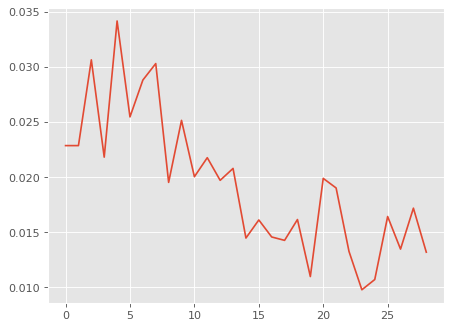

In [ ]:
# DONT RUN THIS CELL
checkpoint = torch.load("/content/drive/MyDrive/NLP_model/G38_model")
model.load_state_dict(checkpoint)


# Move model to cuda
model = model.to('cuda')

tr = time.time()
model.train(True)

best_dev_F1_score = 0.0

# Initliase start time for execution of all the epochs
start_time = time.time()

# Determine the last saved epoch
last_saved_epoch = 5

# Start training from the last saved epoch + 1
for epoch in range(last_saved_epoch + 1, parameters['epoch']):

# # Loop through the epochs
# for epoch in range(1,parameters['epoch']):

    # Initliase start time for execution of per epoch
    start_time_per_epoch = time.time()

    print("-------------- Epoch " + str(epoch) + " --------------")

    # Get data in mini-batches
    for i, index in enumerate(np.random.permutation(len(train_data))):
        count += 1
        data = train_data[index]

        # Set the gradients of all model parameters to zero
        model.zero_grad()

        sentence_in = data['words']
        sentence_in = Variable(torch.LongTensor(sentence_in))
        tags = data['tags']
        chars2 = data['chars']

        # FOR LSTM
        chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
        d = {}
        for i, ci in enumerate(chars2):
            for j, cj in enumerate(chars2_sorted):
                if ci == cj and not j in d and not i in d.values():
                    d[j] = i
                    continue
        chars2_length = [len(c) for c in chars2_sorted]
        char_maxl = max(chars2_length)
        chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
        for i, c in enumerate(chars2_sorted):
            chars2_mask[i, :chars2_length[i]] = c
        chars2_mask = Variable(torch.LongTensor(chars2_mask))


        targets = torch.LongTensor(tags)

        if use_gpu:
            # Get loss
            neg_log_likelihood = model.neg_log_likelihood(sentence_in.to('cuda'), targets.to('cuda'), chars2_mask.to('cuda'), chars2_length, d)
        else:
            # Get loss
            neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d)

        # Get average loss
        loss += neg_log_likelihood.item() / len(data['words'])

        # Perform backpropogation
        neg_log_likelihood.backward()

        # Avoid exploding gradients with the use of gradient clips
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()

        #Storing loss
        if count % plot_every == 0:
            loss /= plot_every
            print(count, ': ', loss)
            if losses == []:
                losses.append(loss)
            losses.append(loss)
            loss = 0.0

    #Evaluating on Train, Test, Dev Sets
    model.train(False)
    best_train_F1_score, new_train_F1_score, _ = performEvaluation(model, train_data, best_train_F1_score,"Train")
    best_dev_F1_score, new_dev_F1_Score, save = performEvaluation(model, dev_data, best_dev_F1_score,"Dev")
    best_test_F1_score, new_test_F1_score, _ = performEvaluation(model, test_data, best_test_F1_score,"Test")

    print("F1 Score of Test Set(Epoch" + str(epoch)+ "): " + str(new_test_F1_score))
    print("F1 Score of Development Set(Epoch" + str(epoch)+ "): " + str(new_dev_F1_Score))
    if save:
        print("Saving Model")
        torch.save(model.state_dict(), "/content/drive/MyDrive/NLP_model/G38_model")


    all_F1_Scores.append([new_train_F1_score, new_dev_F1_Score, new_test_F1_score])
    model.train(True)

    print("The running time to run each epoch: " + str(time.time() - start_time_per_epoch) + " s")

    adjustLearningRate(optimizer, learning_rate=learning_rate/(1+decay_rate*count/len(train_data)))


print("The running time to perform training: " + str(time.time() - start_time) + " s")

print(time.time() - tr)
plt.plot(losses)
plt.show()

-------------- Epoch 10 --------------


<ipython-input-30-9673b0c67e8a>:9: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  start_tags_with_padding = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])


2000 :  0.017801072055355385
4000 :  0.02309376797811614
6000 :  0.016408120106657473
8000 :  0.024127455268095822
10000 :  0.01920241689763682
12000 :  0.022950091924196146
14000 :  0.022940817097537113
Train: new_F1_Score: 0.002418062636562273 best_F1_score: -1.0 
Dev: new_F1_Score: 0.003929507025482257 best_F1_score: 0.0 
Test: new_F1_Score: 0.002190847127555988 best_F1_score: -1.0 
F1 Score of Test Set(Epoch10): 0.002190847127555988
F1 Score of Development Set(Epoch10): 0.003929507025482257
Saving Model
The running time to run each epoch: 2965.505757331848 s
The running time to perform training: 2965.5204224586487 s
2965.5234026908875


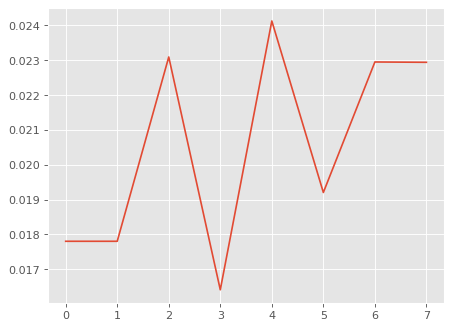

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/NLP_model/G38_model")
model.load_state_dict(checkpoint)


# Move model to cuda
model = model.to('cuda')

tr = time.time()
model.train(True)

best_dev_F1_score = 0.0

# Initliase start time for execution of all the epochs
start_time = time.time()

# Determine the last saved epoch
# last_saved_epoch = 9
epoch = parameters['epoch']

# Initliase start time
start_time_per_epoch = time.time()

print("-------------- Epoch " + str(epoch) + " --------------")

# Get data in mini-batches
for i, index in enumerate(np.random.permutation(len(train_data))):
    count += 1
    data = train_data[index]

    # Set the gradients of all model parameters to zero
    model.zero_grad()

    sentence_in = data['words']
    sentence_in = Variable(torch.LongTensor(sentence_in))
    tags = data['tags']
    chars2 = data['chars']

    # FOR LSTM
    chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
    d = {}
    for i, ci in enumerate(chars2):
        for j, cj in enumerate(chars2_sorted):
            if ci == cj and not j in d and not i in d.values():
                d[j] = i
                continue
    chars2_length = [len(c) for c in chars2_sorted]
    char_maxl = max(chars2_length)
    chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
    for i, c in enumerate(chars2_sorted):
        chars2_mask[i, :chars2_length[i]] = c
    chars2_mask = Variable(torch.LongTensor(chars2_mask))


    targets = torch.LongTensor(tags)

    if use_gpu:
        # Get loss
        neg_log_likelihood = model.neg_log_likelihood(sentence_in.to('cuda'), targets.to('cuda'), chars2_mask.to('cuda'), chars2_length, d)
    else:
        # Get loss
        neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d)

    # Get average loss
    loss += neg_log_likelihood.item() / len(data['words'])

    # Perform backpropogation
    neg_log_likelihood.backward()

    # Avoid exploding gradients with the use of gradient clips
    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
    optimizer.step()

    #Storing loss
    if count % plot_every == 0:
        loss /= plot_every
        print(count, ': ', loss)
        if losses == []:
            losses.append(loss)
        losses.append(loss)
        loss = 0.0

#Evaluating on Train, Test, Dev Sets
model.train(False)
best_train_F1_score, new_train_F1_score, _ = performEvaluation(model, train_data, best_train_F1_score,"Train")
best_dev_F1_score, new_dev_F1_Score, save = performEvaluation(model, dev_data, best_dev_F1_score,"Dev")
best_test_F1_score, new_test_F1_score, _ = performEvaluation(model, test_data, best_test_F1_score,"Test")

print("F1 Score of Test Set(Epoch" + str(epoch)+ "): " + str(new_test_F1_score))
print("F1 Score of Development Set(Epoch" + str(epoch)+ "): " + str(new_dev_F1_Score))
if save:
    print("Saving Model")
    torch.save(model.state_dict(), "/content/drive/MyDrive/NLP_model/G38_model")


all_F1_Scores.append([new_train_F1_score, new_dev_F1_Score, new_test_F1_score])
model.train(True)

print("The running time to run each epoch: " + str(time.time() - start_time_per_epoch) + " s")

adjustLearningRate(optimizer, learning_rate=learning_rate/(1+decay_rate*count/len(train_data)))


print("The running time to perform training: " + str(time.time() - start_time) + " s")

print(time.time() - tr)
plt.plot(losses)
plt.show()

In [ ]:
# timing from epoch 1 + 2 + 3 + 4 + 5 + [6-9] + 10
time_for_all_epoch = 3289.4680638313293 + 2918.7407414913177 + 2921.7061953544617 + 2917.4237031936646 + 3036.317501783371 + 11883.999492645264 + 2965.5204224586487
print ("Total running time:")
print(str(time_for_all_epoch) + "s")

Total running time:
29933.176120758057s
